<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/baseline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-comp

In [2]:
!gdown https://drive.google.com/uc?id=1A8IdrqgEjRhvg9KoV6dopo5GirTKO3aj
!gdown https://drive.google.com/uc?id=1SCxtUqlGEzYCfCbHUREFf5UqoM1uWDBK
!gdown https://drive.google.com/uc?id=1Zh4mCpgQReE4E0sAjiFXwSV6Y7lc77fO
!gdown https://drive.google.com/uc?id=19jT2ZTb6oj6sFERkl5AT3qQExxN3D5cK

Downloading...
From: https://drive.google.com/uc?id=1A8IdrqgEjRhvg9KoV6dopo5GirTKO3aj
To: /content/sns_val.zip
100% 34.8M/34.8M [00:00<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SCxtUqlGEzYCfCbHUREFf5UqoM1uWDBK
To: /content/sns_train.zip
100% 278M/278M [00:01<00:00, 194MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zh4mCpgQReE4E0sAjiFXwSV6Y7lc77fO
To: /content/train.csv
100% 2.24M/2.24M [00:00<00:00, 160MB/s]
Downloading...
From: https://drive.google.com/uc?id=19jT2ZTb6oj6sFERkl5AT3qQExxN3D5cK
To: /content/test.json
100% 417k/417k [00:00<00:00, 89.5MB/s]


In [3]:
!unzip -uq "/content/sns_train.zip" -d "/content/sns_data"
!unzip -uq "/content/sns_val.zip" -d "/content/sns_data"

In [4]:
!pip install transformers

In [5]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

import tensorflow as tf
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertForSequenceClassification   #BERT
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification   #RoBerta
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TFGPT2LMHeadModel

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_df = pd.read_csv("/content/train.csv")

In [7]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9]+", " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    #sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [9]:
train_df["conversation"] = train_df["conversation"].apply(preprocess_sentence)
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 1억만 보내 예 선생님...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [10]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)

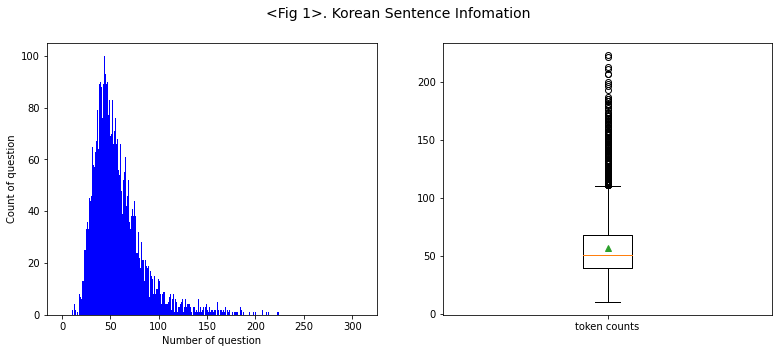

=========================================< Sentence Info >==========================================
길이 최대:     223
길이 최소:      10
길이 평균:     57.330
길이 표준편차:  27.040

 25/100분위:   40.000
 50/100분위:   51.000
 75/100분위:   68.000
 MAX/100분위: 110.000
 IQR:  28.000


In [11]:
sentence_counts = [len(text.split()) for text in train_df["conversation"]]

show_sentence_length(sentence_counts, "<Fig 1>. Korean Sentence Infomation", [0, 310])

In [12]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv',
 '/content/sns_data/content/sns_csv_train/일과직업.csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv']

In [13]:

df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])


In [14]:
'''
df_all = pd.DataFrame()
df_1 = pd.read_csv(files[4])
#df_2 = pd.read_csv(files[4])
df_all = pd.concat([df_all, df_1])
#df_all = pd.concat([df_all, df_2])
df_all
'''

'\ndf_all = pd.DataFrame()\ndf_1 = pd.read_csv(files[4])\n#df_2 = pd.read_csv(files[4])\ndf_all = pd.concat([df_all, df_1])\n#df_all = pd.concat([df_all, df_2])\ndf_all\n'

In [15]:
df_all["class"] = "일반 대화"

In [16]:
df_all.head()

,0,class
0,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...,일반 대화
1,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...,일반 대화
2,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...,일반 대화
3,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...,일반 대화
4,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...,일반 대화


In [17]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [18]:
df_all

,conversation,class
0,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...,일반 대화
1,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...,일반 대화
2,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...,일반 대화
3,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...,일반 대화
4,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...,일반 대화
...,...,...
511550,안뇽여봉~~♡\n여보안뇽~~ 셤보러가는거야~?\n웅ㅋㅋㅋ 도착했어ㅜ #@이모티콘#\...,일반 대화
511551,째릿\n!!! 고기 구워먹는것도 #@이름#이도\n어니 친구들이랑 노는거\n아하 맨날...,일반 대화
511552,ㅋㅋㅋㅋㅋㅋㅋㅋ 웅웅 여보 오후도 회니팅이얌!!!!\n여보도 오후 잘하고있나아 밖에...,일반 대화
511553,생각도 다이어트가 필요하다잖아 내가 그런 타입인듯 ㅋㅋㅋㅋ\n나도 그래 근데 감정적...,일반 대화


In [19]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...
1,일반 대화,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...
2,일반 대화,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...
3,일반 대화,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...
4,일반 대화,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...
...,...,...
511550,일반 대화,안뇽여봉~~♡\n여보안뇽~~ 셤보러가는거야~?\n웅ㅋㅋㅋ 도착했어ㅜ #@이모티콘#\...
511551,일반 대화,째릿\n!!! 고기 구워먹는것도 #@이름#이도\n어니 친구들이랑 노는거\n아하 맨날...
511552,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋ 웅웅 여보 오후도 회니팅이얌!!!!\n여보도 오후 잘하고있나아 밖에...
511553,일반 대화,생각도 다이어트가 필요하다잖아 내가 그런 타입인듯 ㅋㅋㅋㅋ\n나도 그래 근데 감정적...


In [20]:
df_train2 = df_all.sample(n = 4000, random_state = 5)

In [21]:
df_train2["conversation"] = df_train2["conversation"].apply(preprocess_sentence)
df_train2

,class,conversation
383763,일반 대화,이모티콘 그리구 갑자기 이름 오빠분이랑 우웅 밥 같이 먹게 된 것두 미안해 괜찮아 ...
94949,일반 대화,나 어제 이갈았나 이빨 프네 니 가끔 이갈아 그랫을 수도 있어 이 가는 소리 완전 ...
10867,일반 대화,마스크 끈이 작은 건 오래하고 있으면 귀가 아파 응 마스크가 대부분 얼굴보다 작게 ...
93085,일반 대화,저 이거 살까봐요 시스템 사진 그녀의 결정 깜찍합네다 지르세요 저런거 안입어봐서 매...
88247,일반 대화,걱정마 자제중이얌 헤헤 열시전엔 가겠 그자리 그대로 두번옮겼는걸 힝 허끄덕 오늘 다...
...,...,...
46,일반 대화,친구들 강의들어 듣는애들두있구 아닌애들두있구 나 영어수업 돈내고 듣는거 있는데 그거...
66666,일반 대화,아고 내일 새벽에 나가게생겼네 갑자기 이게 무슨 일이람 결국 집으로 가는즁 고생이네...
59451,일반 대화,안됐어요 아그거 절반만되구 기타 세부적으루 볼까요같이 병합하는게 잘안되서 네근데 일...
83626,일반 대화,난 산타고왔당 올 이모티콘 계속하면 살빠질 수이써 화이팅하쟈 끌려갔다옴 생명에 위협...


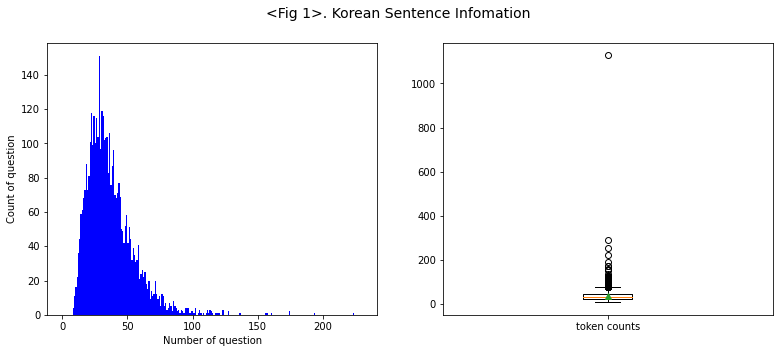

=========================================< Sentence Info >==========================================
길이 최대:    1127
길이 최소:       8
길이 평균:     36.925
길이 표준편차:  25.843

 25/100분위:   24.000
 50/100분위:   33.000
 75/100분위:   45.000
 MAX/100분위:  76.500
 IQR:  21.000


In [22]:
sentence_counts_2 = [len(text.split()) for text in df_train2["conversation"]]

show_sentence_length(sentence_counts_2, "<Fig 1>. Korean Sentence Infomation", [0, 230])

In [23]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1.0,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3.0,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
46,NaN,일반 대화,친구들 강의들어 듣는애들두있구 아닌애들두있구 나 영어수업 돈내고 듣는거 있는데 그거...
66666,NaN,일반 대화,아고 내일 새벽에 나가게생겼네 갑자기 이게 무슨 일이람 결국 집으로 가는즁 고생이네...
59451,NaN,일반 대화,안됐어요 아그거 절반만되구 기타 세부적으루 볼까요같이 병합하는게 잘안되서 네근데 일...
83626,NaN,일반 대화,난 산타고왔당 올 이모티콘 계속하면 살빠질 수이써 화이팅하쟈 끌려갔다옴 생명에 위협...


In [24]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...
46,일반 대화,친구들 강의들어 듣는애들두있구 아닌애들두있구 나 영어수업 돈내고 듣는거 있는데 그거...
66666,일반 대화,아고 내일 새벽에 나가게생겼네 갑자기 이게 무슨 일이람 결국 집으로 가는즁 고생이네...
59451,일반 대화,안됐어요 아그거 절반만되구 기타 세부적으루 볼까요같이 병합하는게 잘안되서 네근데 일...
83626,일반 대화,난 산타고왔당 올 이모티콘 계속하면 살빠질 수이써 화이팅하쟈 끌려갔다옴 생명에 위협...


In [25]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,일반 대화,데이식스 처돌이 될 거 같애 위험해 이미 된거 아니냐 아 빨리 투어끝나고 활동을 해...
1,일반 대화,월요일이라 그런가 댕로 사람 진짜없다 거기 지금 공연도 거의 못하는거아녀 없을만 하...
2,직장 내 괴롭힘 대화,김쌤 내일 주말인데 약속 있어 아니요 교장선생님 없습니다 그럼 내일 나 좀 보지 네...
3,일반 대화,근데 파트 너무상실했던데 열세명이라 어쩔수업나 버논이도 무매력 멤이라 했는데 무대에...
4,기타 괴롭힘 대화,너 엄마 없어 아 응 왜 뭐때문에 아빠가 술 좋아하셔서 아 술 폭행 아 너도 참 불...
...,...,...
7945,직장 내 괴롭힘 대화,장원씨 오늘 왜이렇게 조용해요 일하니까요 말 좀 해봐요 노래 부르던지 네 아니 평소...
7946,일반 대화,식기로 보고있는거야 어어 나도 쫌 봐야겠따 안살거지만 이사갈때 다 버리고 새마음으로...
7947,일반 대화,아 나 근데 속이 너무 아파가지고 잠이나 잘수잇을런지 모르겟어 많이 아파서 어떡해 ...
7948,직장 내 괴롭힘 대화,너 오늘 남아라 오늘은 안됩니다 가긴 어딜가 남으라고 이유라도 말 해주세요 너 내 ...


In [26]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(df_train, "conversation", 100)

In [27]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df_train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

df_train["class"] = bucket_class
df_train.head()

,class,conversation
0,4,데이식스 처돌이 될 거 같애 위험해 이미 된거 아니냐 아 빨리 투어끝나고 활동을 해...
1,4,월요일이라 그런가 댕로 사람 진짜없다 거기 지금 공연도 거의 못하는거아녀 없을만 하...
2,2,김쌤 내일 주말인데 약속 있어 아니요 교장선생님 없습니다 그럼 내일 나 좀 보지 네...
3,4,근데 파트 너무상실했던데 열세명이라 어쩔수업나 버논이도 무매력 멤이라 했는데 무대에...
4,3,너 엄마 없어 아 응 왜 뭐때문에 아빠가 술 좋아하셔서 아 술 폭행 아 너도 참 불...


In [28]:
X = df_train["conversation"].to_list()
Y = df_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 7155
y_train 개수 : 7155
x_val 개수 : 397
y_val 개수 : 397
x_test 개수 : 398
y_test 개수 : 398
훈련 데이터 레이블 비율 확인 : Counter({4: 3600, 3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({4: 200, 3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({4: 200, 3: 55, 2: 49, 1: 49, 0: 45})


In [29]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base", use_fast=True)

In [30]:

train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

In [31]:
x_train[0]

'배우 이시언은 주택청약당첨됐었나봐 나혼자산다에서 봤지 응 친구가 계속 하라고 해서 했는데 당첨됐대 친구한테 엄청 고마워해야겠다 그러니까 엄청 좋은 친구를 둔거같아 응 주택청약당첨되기 힘들다던데 운도 좋다 응 아파트값이 엄청 올랐나봐 진짜 부럽다 타고난 팔자가 있는건가 싶어'

In [32]:
for key in train_encodings:
  print(f"{key} : {train_encodings[key][1]}")

input_ids : [2, 4119, 4035, 14802, 2019, 2044, 2173, 4652, 2181, 4229, 1238, 2154, 4284, 2507, 13964, 23701, 1332, 2154, 4284, 21721, 4224, 717, 2119, 772, 2318, 2031, 2051, 3254, 13964, 2119, 6646, 2460, 4190, 2066, 11336, 2031, 2073, 809, 8183, 4486, 1085, 2606, 2220, 2088, 1830, 2886, 2069, 2088, 2173, 5785, 5403, 31155, 2244, 5370, 6970, 2052, 2689, 13091, 2097, 3853, 2396, 3797, 1378, 7471, 3934, 1376, 3672, 25072, 4313, 2073, 16557, 2275, 2097, 3672, 16557, 2275, 2723, 28674, 4224, 918, 11466, 16557, 2275, 2097, 12316, 1521, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:


train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), 
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), 
                                                  y_val))

In [34]:
num_labels = max(df_train["class"]) + 1
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", 
                                                        num_labels=num_labels, 
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
#bert_model.summary()
#kbert_model.summary()
#robert_model.summary()

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)


#kbert_model.fit(
#    kbert_train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
#    validation_data=kbert_val_dataset.shuffle(1000).batch(16),
#    callbacks = [callback_earlystop]
#)

#robert_model.fit(
#    robert_train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
#    validation_data=robert_val_dataset.shuffle(1000).batch(16),
#    callbacks = [callback_earlystop]
#)

In [37]:
model.fit(
    train_dataset.shuffle(1000).batch(8), epochs=1, batch_size=8,
    validation_data=val_dataset.shuffle(1000).batch(8),
    callbacks = [callback_earlystop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


895/895 [==============================] - 533s 575ms/step - loss: 0.3275 - accuracy: 0.8910 - val_loss: 0.2011 - val_accuracy: 0.9395


In [38]:

model_path = "./model/fine-tuned-klue-robert-base"

model.save_pretrained(model_path)

tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-robert-base/tokenizer_config.json',
 './model/fine-tuned-klue-robert-base/special_tokens_map.json',
 './model/fine-tuned-klue-robert-base/vocab.txt',
 './model/fine-tuned-klue-robert-base/added_tokens.json',
 './model/fine-tuned-klue-robert-base/tokenizer.json')

In [39]:
# Load Fine-tuning model
model_path = "./model/fine-tuned-klue-robert-base"

loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)


text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue-robert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue-robert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [40]:

predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]


    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 398/398 [03:17<00:00,  2.02it/s]


In [41]:

y_pred = [int(label[-1]) for label in predicted_label_list]

y_true = y_test

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        45
           1       0.88      0.88      0.88        49
           2       0.98      0.92      0.95        49
           3       0.87      0.87      0.87        55
           4       0.99      0.97      0.98       200

    accuracy                           0.94       398
   macro avg       0.91      0.92      0.91       398
weighted avg       0.94      0.94      0.94       398



In [42]:

false_list = []



for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [43]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
9,저희 밥 먹으러 가요 좋아요 좋아 오늘 불고기 어때요 좋죠 다 같이 가는 건가요 네...,2,3
72,넌 진짜 일단 맞자 아 진짜 왜그러냐 조금 실수한 거 갖고 왜 그래 그게 조금이냐 ...,0,3
84,어허 황금에서 손을 떼시지 이 녀석 총으로 나를 겨냥하다니 흐흐흐 아쉽지만 우린 여...,1,0
85,잘했다 믓찌네 니가 괜찮다며 응 이쁘지 벌써 샀나 싶어서 난 좀 더 나중에 살줄 언...,4,1
95,야 빨리 일해 노닥 거리지 말고 물류 물량 더 들어온다 야 색꺄 똑바로 안해 죄송합...,2,3
105,엄마 다녀왔습니다 야이 미친년아 지금 몇시라고 기어들어오는거야 야자 끝나고 버스를 ...,3,0
128,민지 씨 이번주말에 뭐해요 저는 남자친구만납니다 아 우리 애랑 선좀 보라고하려했는데...,2,3
152,오 신발샀냐 응 전에 신던게 다 헤져서 부모님이 사주셨어 니네 집 꽤 사나보다 이런...,3,1
179,다들 엎드려 살고싶으면 살 살려주세요 내가 왜 이짓을 하는지 알겠지 빨리 현금 뽑아...,1,0
189,이거 선물임다 갑자기 뭐죠 쓰시라구요 왜이러세요 저 월급받았는데요 부를 나눠주고싶엇...,4,1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_

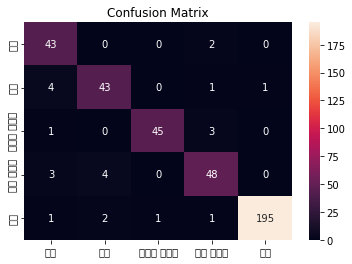

In [44]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [45]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,43,0,0,2,0
갈취,4,43,0,1,1
직장내 괴롭힘,1,0,45,3,0
기타 괴롭힘,3,4,0,48,0
일반,1,2,1,1,195


In [46]:
pip install transformers-interpret

In [47]:
"""
일단!!!
미리 만들어둔 모델들을 불러와야 합니다.
 
위의 Huggingface 모델에서 생성하고 저장 한 위치를 model과 tokenizer에 지정해주면 Auto기능 이 자동으로 해당
자료를 감지하여 가져옵니다. (신기합니다.)

"""
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
#모델 불러오기 
model =  AutoModelForSequenceClassification.from_pretrained("./model/fine-tuned-klue-robert-base", from_tf=True) 
tokenizer = AutoTokenizer.from_pretrained("./model/fine-tuned-klue-robert-base")

#다중분류 설명자 생성
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [48]:
fake_sample_text="""안녕하세요 저는 송영석 입니다. 자기소개를 시작하겠습니다. 저는 어릴적 강도질과 폭력을 일 삼았고 학창시절에는 나쁜 일들을 많이 저질렀습니다. 사람을 죽이고 싶었던 적이 많고 물건도 다 훔치고 빼았았습니다. 저는 죄를 반성하고 있습니다 """
general_sample_text = """김 부사장은 삼성전자가 현재 만들고 있는 반도체들의 구조 변화와 전망을 개괄적으로 설명했습니다. 삼성전자 주력인 D램, 낸드플래시 등 메모리 반도체부터 이미지센서, 시스템 반도체 구조와 미래까지 개괄적으로 조망한 점이 눈에 띕니다. """

In [49]:
word_attributions = multiclass_explainer(text=fake_sample_text)
html = multiclass_explainer.visualize()

In [50]:
# 점수가 높을 수록 해당 클래스가 나오게 하는데 기여를 많이한 부분이고 
# 점수가 낮을 수록 관여를 적게한 부분입니다.

word_attributions

[('[CLS]', 0.0),
 ('안녕', -0.028668595618972587),
 ('##하', -0.0036806361595821927),
 ('##세요', 0.06639374077045823),
 ('저', 0.0597656708263041),
 ('##는', 0.10409623560523427),
 ('송영', 0.17872908608869006),
 ('##석', 0.11867197418581439),
 ('입니다', 0.10627868020607682),
 ('.', 0.06766137074249218),
 ('자기', 0.32221254642930897),
 ('##소', -0.04786370987309845),
 ('##개', 0.09436405668298614),
 ('##를', 0.0013877222896402227),
 ('시작', -0.01630732015138838),
 ('##하', 0.033642821921444244),
 ('##겠', 0.07348177387543275),
 ('##습', 0.04194603872378053),
 ('##니다', 0.0665922248439699),
 ('.', 0.047019796832051555),
 ('저', 0.025111551912835855),
 ('##는', 0.05776045877830592),
 ('어릴', 0.09071464183380532),
 ('##적', 0.028080468623259643),
 ('강도', -0.0016318102703865816),
 ('##질', 0.09018985129223919),
 ('##과', 0.021852470796029175),
 ('폭력', 0.1567922669640231),
 ('##을', 0.06377957678530817),
 ('일', 0.05145439012957183),
 ('삼', -0.005835487858033662),
 ('##았', -0.003117812624277986),
 ('##고', 0.0348644204

In [51]:
#진짜 일반 대화 test
word_attributions = multiclass_explainer(text=general_sample_text)
html = multiclass_explainer.visualize()

In [52]:
word_attributions 

[('[CLS]', 0.0),
 ('김', -0.17818196411757445),
 ('부사장', -0.49056530381666597),
 ('##은', 0.11016127630157915),
 ('삼성전자', -0.27998663609547214),
 ('##가', -0.04330409414606141),
 ('현재', -0.06688665340338387),
 ('만들', -0.01898579713321863),
 ('##고', 0.025094557838770147),
 ('있', -0.014675282144846894),
 ('##는', -0.04375392337913248),
 ('반도체', -0.46286806081027004),
 ('##들', -0.13451794457631777),
 ('##의', -0.04873598697260729),
 ('구조', -0.13216112315048606),
 ('변화', -0.0899347474838933),
 ('##와', -0.04325093467855514),
 ('전망', -0.07642879488890382),
 ('##을', -0.0746500234370469),
 ('개', -0.06351705423881461),
 ('##괄', -0.059135285130041494),
 ('##적으로', -0.10300889454711962),
 ('설명', -0.14003101646217447),
 ('##했', -0.12486172813428066),
 ('##습', -0.08640164550667635),
 ('##니다', -0.18016077676786327),
 ('.', 0.04614120294589985),
 ('삼성전자', -0.22763920614620012),
 ('주력', -0.09731088778407365),
 ('##인', -0.023451635665019677),
 ('D', -0.020011633601715616),
 ('##램', -0.04853429855675075),
 ('